In [1]:
import os
import glob
import json
import face_recognition

import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm_notebook
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Установка face_recognition
# https://gist.github.com/jk195417/76afbb7ac8ce30afb04bcd72eafc5aff

# Импорт данных

In [4]:
with open('config/actress_actors.json', 'r') as fp:
    dict_act = json.load(fp)

In [ ]:
# Посмотрим предварительно на кол-во фото, которые удалось выгрузить
dict_labels = dict()
for i, key in enumerate(dict_act['men']):
    dict_labels[key] = i

In [6]:
embedings = np.empty(128)
target = []

key = 'men'

for person in tqdm_notebook(list(dict_labels.keys())):
    files = len(glob.glob(f'dataset/men/{person}/*'))   
    if files < 2:
        print(f'Убираем из датасета: {person}')
    else:
        # получаем список изображений внутри папки
        images = os.listdir(f"./dataset/{key}/{person}")
        len_images = len(images)

        for num, person_img in enumerate(images):
            try:
                if person_img != '.DS_Store':
                    # Считыаем изображение
                    face = face_recognition.load_image_file(
                        f"dataset/{key}/{person}/{person_img}")
                    # Получаем координаты лица
                    face_bounding_boxes = face_recognition.face_locations(face)

                    # Если более одного лица на фото, либо их нет, то пропуск
                    if len(face_bounding_boxes) == 1:
                        try:
                            # Преобразуем фото с лицом в вектор, получаем embeding
                            face_enc = face_recognition.face_encodings(face)[0]

                            # Добавляем в датасет матрицу
                            embedings = np.vstack((embedings, face_enc))

                            # Добавляем таркет по текущему индексу
                            target.append(dict_labels[person])

                        except Exception as ex:
                            print(f'Error message {ex}')
            except Exception as ex:
                print(f'Error message {ex}')

<ipython-input-6-ce070a9d0a86>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for person in tqdm_notebook(list(dict_labels.keys())):


In [7]:
# Удаляем из датасета первый элемент, так как это пустая матрица
embedings_ = embedings[1:]

# Обучение модели

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    embedings_, target, test_size=0.3, stratify=target, random_state=42)

In [13]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [14]:
f1 = f1_score(y_test, clf.predict(X_test), average='micro')

print(f'F1 score = {f1}')

F1 score = 0.7790262172284643


# Тестирование на реальном фото

In [15]:
def resize_image(SIZE, image):
    # получим его размер
    size = image.size

    # получим коэффициент, на который нужно уменьшить/увеличить
    # изображение по одной из сторон до 256
    coef = SIZE / size[0]
    # изменяем размер изображения
    resized_image = image.resize(
        (int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    return res_image

In [16]:
SIZE = 1024

image = Image.open('img_test/test.jpg')
res_image = resize_image(SIZE, image)
res_image.save('img_test/test_res.jpg')

In [ ]:
plt.imshow(res_image);

In [18]:
def predict_actress(path, model, dict_labels):
    face = face_recognition.load_image_file(path)
    face_bounding_boxes = face_recognition.face_locations(face)
    
    if len(face_bounding_boxes) != 1:
        print('Problem with find face')
    else:
        # Преобразуем фото с лицом в вектор, получаем embeding 
        face_enc = face_recognition.face_encodings(face)[0]
        
        # Предикт actress/actor
        predict = clf.predict([face_enc])
        predict_labels = list(dict_labels.keys())[list(dict_labels.values()).index(predict)]
        
        preict_proba = clf.predict_proba([face_enc])
        
        return predict_labels, preict_proba

In [ ]:
predict_name, preict_proba = predict_actress('img_test/test_res.jpg', clf, dict_labels)
predict_name

In [20]:
# таблица со скорами
df = pd.DataFrame()

df['act'] = list(dict_labels.keys())[:]
df['score'] = preict_proba[0]

In [ ]:
df.sort_values(by='score')[::-1]

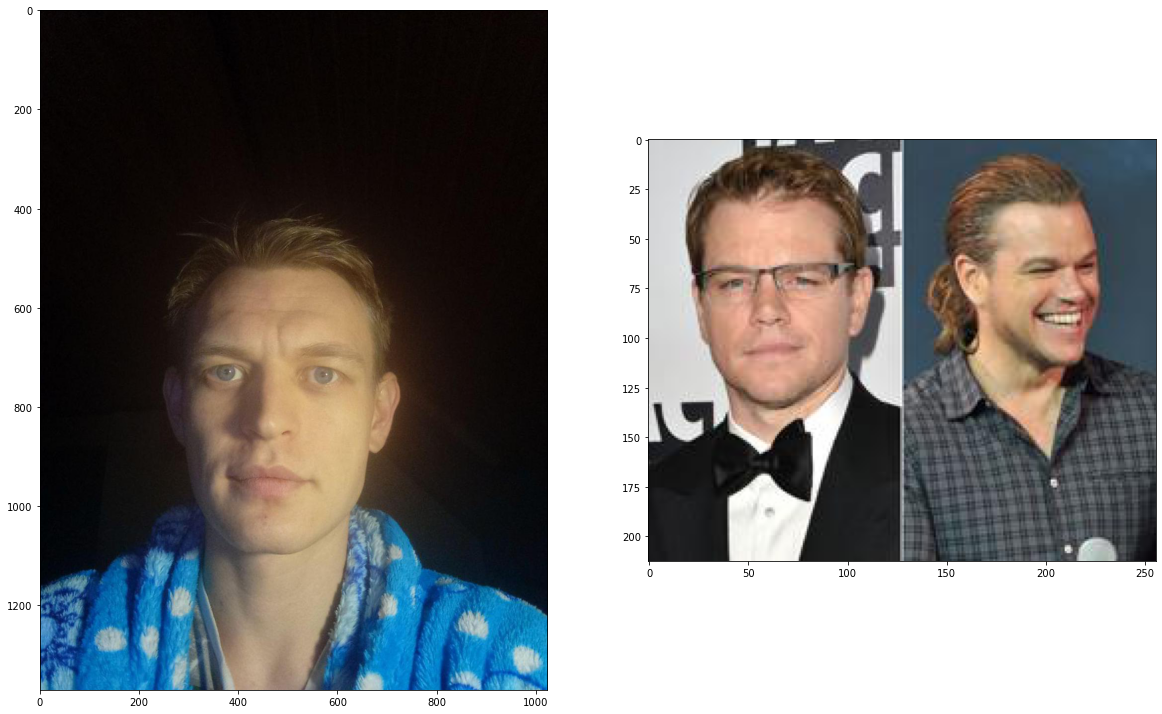

In [24]:
num_image = 11

image1 = face_recognition.load_image_file("img_test/test_res.jpg")
image2 = face_recognition.load_image_file(f"dataset/men/{predict_name}/Image_{num_image}.jpg")

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(image1)
ax[1].imshow(image2);

# Получение средней оценки cosine

In [25]:
def comparison(path_test, name_act, num_image):
    # лицо в качестве теста
    face_1 = face_recognition.load_image_file(path_test)
    face_enc_1 = face_recognition.face_encodings(face_1)[0]
    
    # актриса
    path_act = f"dataset/men/{name_act}/Image_{num_image}.jpg"
    
    face_2 = face_recognition.load_image_file(path_act)
    face_enc_2 = face_recognition.face_encodings(face_2)[0]
    
    return cosine_similarity(face_enc_1.reshape(1, -1), face_enc_2.reshape(1, -1))[0]

In [29]:
predict_name = 'Matt Damon'

len_files = len(glob.glob(f'dataset/men/{predict_name}/*'))
cos = []

for i in tqdm_notebook(range(len_files)):
    try:
        cos_ = comparison('img_test/test_res.jpg', predict_name, i)
        cos.append(cos_)
        print(i, cos_)
    except Exception as ex:
        print(f'message: {ex}')
        
print(f'Mean score = {np.mean(cos)}')

<ipython-input-29-18ded7e2a939>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len_files)):


message: [Errno 2] No such file or directory: 'dataset/men/Matt Damon/Image_0.jpg'
1 [0.89544727]
2 [0.89904304]
3 [0.82270861]
4 [0.86931547]
5 [0.90597679]
6 [0.86181659]
7 [0.89910403]
8 [0.86958512]
9 [0.87680601]
10 [0.90524117]
11 [0.89629345]
message: list index out of range
13 [0.88214935]
14 [0.88297897]

Mean score = 0.8820358359831239
